In [1]:
import math
from typing import Dict, Tuple, Optional, List

import torch
from torch import nn
from torch.autograd import grad
from torch.func import jvp as jvp_fwd


# ================================================================
# Core stacked layers (vectorized over support-set axis K)
# ================================================================
class StackedLinear(nn.Module):
    """
    Per-k linear layers evaluated in parallel.
    Weight: [K, out, in], Bias: [K, out]
    Forward expects x: [B, K, in] -> y: [B, K, out]
    """
    def __init__(self, K: int, in_features: int, out_features: int, bias: bool = True):
        super().__init__()
        self.K = int(K)
        self.in_features = int(in_features)
        self.out_features = int(out_features)

        # [K, out, in]
        self.weight = nn.Parameter(
            torch.empty(self.K, self.out_features, self.in_features)
        )
        if bias:
            self.bias = nn.Parameter(torch.empty(self.K, self.out_features))
        else:
            self.register_parameter("bias", None)

        self.reset_parameters()

    def reset_parameters(self):
        # K independent Kaiming-uniform initializations
        for k in range(self.K):
            nn.init.kaiming_uniform_(self.weight.data[k], a=math.sqrt(5))
        if self.bias is not None:
            fan_in = self.in_features
            bound = 1 / math.sqrt(fan_in) if fan_in > 0 else 0
            nn.init.uniform_(self.bias.data, -bound, bound)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x: [B, K, in]
        # y[b,k,o] = sum_i x[b,k,i] * W[k,o,i] + b[k,o]
        y = torch.einsum("bki,koi->bko", x, self.weight)
        if self.bias is not None:
            y = y + self.bias.unsqueeze(0)  # [1,K,out]
        return y


class OutputBatchNormPerK(nn.Module):
    """
    BatchNorm applied per (k, channel) using batch statistics over B only.
    x: [B, K, C] -> y: [B, K, C]

    Keeps running_mean/var per (K,C). Supports affine per (K,C).
    This preserves BatchNorm semantics for each potential independently.
    """
    def __init__(
        self,
        K: int,
        C: int,
        eps: float = 1e-5,
        momentum: float = 0.1,
        affine: bool = True,
        track_running_stats: bool = True,
    ):
        super().__init__()
        self.K = int(K)
        self.C = int(C)
        self.eps = float(eps)
        self.momentum = float(momentum)
        self.affine = bool(affine)
        self.track_running_stats = bool(track_running_stats)

        if self.affine:
            self.weight = nn.Parameter(torch.ones(self.K, self.C))  # gamma
            self.bias = nn.Parameter(torch.zeros(self.K, self.C))   # beta
        else:
            self.register_parameter("weight", None)
            self.register_parameter("bias", None)

        if self.track_running_stats:
            self.register_buffer("running_mean", torch.zeros(self.K, self.C))
            self.register_buffer("running_var", torch.ones(self.K, self.C))
            self.register_buffer("num_batches_tracked", torch.tensor(0, dtype=torch.long))
        else:
            self.register_buffer("running_mean", None)
            self.register_buffer("running_var", None)
            self.register_buffer("num_batches_tracked", None)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        assert x.dim() == 3 and x.size(1) == self.K and x.size(2) == self.C, (
            f"Expected [B,K,{self.C}] got {tuple(x.shape)}")
        B = x.size(0)

        if self.training:
            mean = x.mean(dim=0)  # [K,C]
            var = x.var(dim=0, unbiased=False)  # [K,C]

            if self.track_running_stats:
                with torch.no_grad():
                    self.num_batches_tracked += 1
                    m = self.momentum
                    self.running_mean.mul_(1 - m).add_(m * mean)
                    self.running_var.mul_(1 - m).add_(m * var)
        else:
            if self.track_running_stats:
                mean = self.running_mean
                var = self.running_var
            else:
                # fall back to batch stats if not tracking
                mean = x.mean(dim=0)
                var = x.var(dim=0, unbiased=False)

        y = (x - mean.unsqueeze(0)) / torch.sqrt(var.unsqueeze(0) + self.eps)
        if self.affine:
            y = y * self.weight.unsqueeze(0) + self.bias.unsqueeze(0)
        return y


class StackedSinusoidalPositionEmbeddings(nn.Module):
    """
    Sinusoidal embedding broadcast over K.
    Input: t [B, K, 1] -> emb [B, K, E]; E must be even.
    """
    def __init__(self, emb_dim: int):
        super().__init__()
        assert emb_dim % 2 == 0, "time embedding dim should be even"
        self.emb_dim = int(emb_dim)
        half_dim = emb_dim // 2
        emb_scale = math.log(10000.0) / max(half_dim - 1, 1)
        freqs = torch.exp(torch.arange(half_dim) * -emb_scale)
        self.register_buffer("freqs", freqs, persistent=False)

    def forward(self, t: torch.Tensor) -> torch.Tensor:
        # t: [B,K,1]
        angles = t * self.freqs.view(1, 1, -1).to(t.dtype)  # [B,K,half]
        return torch.cat([angles.sin(), angles.cos()], dim=-1)  # [B,K,E]


# ================================================================
# Stacked potentials: f (SemanticPotential) and ψ (SliceEnergy)
#   - Hidden layers have NO BatchNorm per your requirement
#   - Only the FINAL output of f (and optionally ψ) is BatchNormed per-k
# ================================================================
class StackedSemanticPotential(nn.Module):
    def __init__(self, K: int, n_in: int, n_out: int = 1, n_hidden: int = 128,  activation: nn.Module = nn.Tanh(), final_activation: nn.Module = nn.Identity()):
        super().__init__()
        self.K = int(K)
        self.n_in = int(n_in)
        self.n_out = int(n_out)
        self.n_hidden = int(n_hidden)

        self.fc1 = StackedLinear(self.K, self.n_in, self.n_in)
        self.act1 = activation

        self.fc2 = StackedLinear(self.K, self.n_in, self.n_hidden)
        self.act2 = activation

        self.fc3 = StackedLinear(self.K, self.n_hidden, self.n_hidden)
        self.act3 = activation

        self.fc4 = StackedLinear(self.K, self.n_hidden, self.n_out)

        # Additional linear component from input to output, initialized to random unit directions (per k)
        self.dir_linear = StackedLinear(self.K, self.n_in, self.n_out, bias=False)
        with torch.no_grad():
            W = self.dir_linear.weight.data  # [K, out(=1), in]
            # normalize each row vector (per k, per out)
            norms = W.norm(dim=-1, keepdim=True).clamp_min_(1e-8)  # [K,1,1]
            W.normal_()
            W.div_(norms)

        # Output-only BatchNorm per k
        self.out_bn = OutputBatchNormPerK(self.K, self.n_out)
        self.final_activation = final_activation

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x: [B,K,D]
        h = self.act1(self.fc1(x))
        h = self.act2(self.fc2(h))
        h = self.act3(self.fc3(h))
        out = self.fc4(h) + self.dir_linear(x)  # [B,K,1]
        out = self.out_bn(out)
        return self.final_activation(out)


    def update_y_distributions(self, y: torch.Tensor):
        """
        Update the density estimates for each k. This should stay implementation-agnostic with a plug-in estimator class call.
        """
        pass


class StackedSliceEnergy(nn.Module):
    def __init__(self, K: int, n_in: int, n_out: int = 1, n_hidden: int = 64, final_activation: nn.Module = nn.Identity(),
                 apply_output_bn: bool = False):
        super().__init__()
        self.K = int(K)
        self.n_in = int(n_in)
        self.n_out = int(n_out)
        self.n_hidden = int(n_hidden)


        # x pathway
        self.layer_x = StackedLinear(self.K, self.n_in, self.n_in)
        self.activation1 = nn.Tanh()

        # time pathway (uses sinusoidal embeddings of size n_in)
        self.layer_pos = StackedSinusoidalPositionEmbeddings(self.n_hidden)
        self.layer_time = StackedLinear(self.K, self.n_hidden, self.n_hidden)
        self.activation2 = nn.GELU()
        self.layer_time2 = StackedLinear(self.K, self.n_hidden, self.n_in)

        # fusion + output
        self.layer_fusion = StackedLinear(self.K, self.n_in, self.n_in)
        self.activation3 = nn.Tanh()
        self.layer_out = StackedLinear(self.K, self.n_in, self.n_out)
        self.activation4 = nn.Tanh()

        self.apply_output_bn = bool(apply_output_bn)
        self.out_bn = OutputBatchNormPerK(self.K, self.n_out) if self.apply_output_bn else None

    def forward(self, x: torch.Tensor, time: torch.Tensor) -> torch.Tensor:
        # x: [B,K,D], time: [B,K,1]
        xh = self.activation1(self.layer_x(x))
        t_feat = self.layer_pos(time)
        t_feat = self.layer_time(t_feat)
        t_feat = self.activation2(t_feat)
        t_feat = self.layer_time2(t_feat)

        h = self.activation3(self.layer_fusion(xh + t_feat))
        out = self.activation4(self.layer_out(h))  # [B,K,1]
        if self.apply_output_bn:
            out = self.out_bn(out)
        return out
# wave_pde.py
import torch
from torch import nn
from typing import Dict, Optional, List

from lib.pde_ops import PDEState
from lib.pde_losses import build_losses 

class WavePDE(nn.Module):
    """
    K-parallel WavePDE powered by PDEState and modular PDE losses.
    """
    def __init__(
        self,
        num_support_sets: int,
        num_support_timesteps: int,
        support_vectors_dim: int,
        lambdas: Dict[str, float] = {},                   # ONLY what you want active (may include 0.0)
        n_laplace_probes: int = 1,
        apply_bn_on_psi_output: bool = False,
        # PDEState config
        time_ad: str = "reverse",
        detach_between_steps: bool = True,
        eps_norm2: float = 1e-8,
        divergence_probes: int = 1,
        rng: str = "rademacher",
        seed: Optional[int] = None,
        # optional: prior score function for DivPrior (defaults to Gaussian score -x)
        prior_score: Optional[callable] = None,
    ):
        super().__init__()
        self.num_support_sets = int(num_support_sets)
        self.num_support_timesteps = int(num_support_timesteps)
        self.support_vectors_dim = int(support_vectors_dim)

        # Learnable per-k scale (kept for parity; not wired to dt by default)
        self.c = nn.Parameter(torch.full((self.num_support_sets, 1), 1.0))

        # Stacked potentials
        self.PSI = StackedSliceEnergy(
            K=self.num_support_sets,
            n_in=self.support_vectors_dim,
            n_out=1,
            final_activation=nn.Identity(),
            apply_output_bn=apply_bn_on_psi_output,
        )
        self.F = StackedSemanticPotential(
            K=self.num_support_sets,
            n_in=self.support_vectors_dim,
            n_out=1,
            final_activation=nn.Identity(),
        )

        # PDEState config for each step
        self._pde_cfg = dict(
            time_ad=time_ad,
            detach_between_steps=detach_between_steps,
            eps_norm2=eps_norm2,
            laplace_probes=int(n_laplace_probes),
            divergence_probes=int(divergence_probes),
            rng=rng,
            seed=seed,
        )

        # Build modular loss list from registry (only specified keys are included).
        # Pass modules/params needed by certain losses through ctx.
        epsilon = float(lambdas.get("epsilon", 0.0))  # a scalar param (not a loss)
        self.losses, self._needs_next = build_losses(
            lambdas,
            F=self.F,
            epsilon=epsilon,
            prior_score=prior_score,
        )

        # for telemetry
        self._acc: Dict[str, torch.Tensor] = {}

    # ---- one step ----
    def _per_step(self, z_bkd: torch.Tensor, direction: int = +1):
        st = PDEState(
            f=self.F,
            psi=self.PSI,
            z=z_bkd,
            direction=direction,
            need_next=self._needs_next,
            dt_value=1.0,  # use ±1 step; wire self.c here if desired
            **self._pde_cfg,
        )

        # compute & sum selected losses [B,K,1]
        per_bk = [L(st) for L in self.losses]
        L_sum = sum(per_bk) if per_bk else st.zeros()  # if no losses, zero tensor

        # next latent (semi-implicit Euler @ now)
        x_next = st.x_next()

        # (optional) same small step noise as before
        with torch.no_grad():
            step_delta_norms = (x_next - st.x()).norm(dim=-1, keepdim=True)
            latent_noise = torch.randn_like(x_next)
            latent_noise = latent_noise / latent_noise.norm(dim=-1, keepdim=True).clamp_min_(1e-12)
            latent_noise = latent_noise * (step_delta_norms / 5.0)
        x_next_noisy = x_next + latent_noise

        return st, x_next_noisy, L_sum

    # ---- unrolled training ----
    def forward(self, z: torch.Tensor, t_index: torch.Tensor, direction: int = +1):
        """
        Returns:
          potential_preds: [B,K,1] (detached)
          latent1_bk, latent2_bk: [B,K,D] (pair captured at t_index)
          L_total_mean: scalar
        """
        B, D = z.shape
        K = self.num_support_sets
        T = max(1, int(self.num_support_timesteps))

        if t_index.ndim == 1:
            t_index = t_index.unsqueeze(-1)
        i_target = torch.clamp(t_index, 0, T - 1).long().squeeze(-1)

        # expand once to K stacks
        z_curr = z.unsqueeze(1).expand(B, K, D).contiguous()

        latent1_bk = None
        latent2_bk = None
        last_st: Optional[PDEState] = None

        L_accum = None  # accumulate per-[B,K,1]

        step_iter = range(T) if direction == +1 else reversed(range(T))
        for i in step_iter:
            st, x_next, L_step = self._per_step(z_curr, direction=direction)

            # accumulate loss per step
            L_accum = (L_step if L_accum is None else L_accum + L_step)

            # capture (latent1, latent2) at the requested index
            mask_b = (i_target == i).view(B, 1, 1)
            if latent1_bk is None:
                latent1_bk = torch.where(mask_b, z_curr, torch.zeros_like(z_curr))
                latent2_bk = torch.where(mask_b, x_next, torch.zeros_like(x_next))
            else:
                latent1_bk = torch.where(mask_b, z_curr, latent1_bk)
                latent2_bk = torch.where(mask_b, x_next, latent2_bk)

            # advance
            z_curr = x_next
            last_st = st

        # average over steps
        L_total_per_bk = L_accum / float(T) if L_accum is not None else last_st.zeros()
        L_total_mean = L_total_per_bk.mean()

        # telemetry
        potential_preds = last_st.f().detach() if last_st is not None else torch.zeros(B, K, 1, device=z.device, dtype=z.dtype)
        
        self._acc = {
            "xf_now": last_st.Xf() if last_st is not None else torch.zeros(B, K, D, device=z.device, dtype=z.dtype),
            "L_mean": L_total_mean.detach(),
            **last_st.state["losses"],
        }
        return potential_preds, latent1_bk, latent2_bk, L_total_mean

    def get_losses(self) -> Dict[str, torch.Tensor]:
        return self._acc

    @torch.enable_grad()
    def inference(self, z: torch.Tensor, direction: int = +1) -> List[torch.Tensor]:
        B, D = z.shape
        K = self.num_support_sets
        T = max(1, int(self.num_support_timesteps))
        traj: List[torch.Tensor] = []

        z_curr = z.unsqueeze(1).expand(B, K, D).contiguous()
        traj.append(z_curr)

        for _ in (range(T) if direction == +1 else reversed(range(T))):
            st = PDEState(
                f=self.F,
                psi=self.PSI,
                z=z_curr,
                direction=direction,
                need_next=False,
                dt_value=1.0,
                **self._pde_cfg,
            )
            z_next = st.x() + st.dt() * st.v("now")
            traj.append(z_next)
            z_curr = z_next
        return traj


ModuleNotFoundError: No module named 'lib.pde_ops'

In [ ]:
#@title init
import pickle
import torch
import torch.nn.functional as F
import sys
import shutil
import torchvision.transforms.functional as TF
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
from sklearn.model_selection import train_test_split
import csv
import numpy as np
import pandas as pd
import PIL.Image
from PIL import Image, ImageDraw
import IPython.display
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm
from ipywidgets import interact, Button, FloatSlider, Layout
import sys

import io
import os, time
import pickle
import shutil
import numpy as np
import torch
import torch.nn.functional as F
import requests
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
import copy
import unicodedata
import re
from PIL import Image
from tqdm.notebook import tqdm
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
from IPython.display import display
from einops import rearrange
from time import perf_counter

# df = pd.read_hdf('coords_wlosses.h5')
#   
df = pd.read_csv('/Users/adamsobieszek/PycharmProjects/psychGAN/content/coords_wlosses.csv')
sys.path.append('/Users/adamsobieszek/PycharmProjects/_manipy/')

In [ ]:
import torch
import numpy as np
import pandas as pd
from pathlib import Path
from torchvision.transforms import Compose, Resize
import torchvision.transforms.functional as TF
from typing import List, Dict, Union, Tuple
%cd /Users/adamsobieszek/PycharmProjects/_manipy/
# Assuming the existence of these from a library like torchdyn
from torchdyn.core import NeuralODE
from torchdyn.datasets import *
from torchdyn.models import *


from manipy.models.flow_models import VectorFieldTransformer, RatingODE
from manipy.models.layers import EnsembleRegressor, MeanRegressor
from manipy.models.rating_models import AlphaBetaRegressor

from manipy.stylegan.utils import sample_w, G_context

final_models_path = "/Users/adamsobieszek/PycharmProjects/psychGAN/content/"
device = torch.device('mps')

# del control_models
if not "control_models" in dir():
  # if not os.path.exists("final_models.zip"):
  #   !gdown 1pPjOd-mx-d-vOw1QR_lpJoJmLAGdkI3W
  #   !unzip final_models.zip
  #   !unzip final_models.zip
  control_names = ['happy', 'gender', 'age', 'black', 'trustworthy','attractive','smart', 'dominant', 'asian', 'white']
  control_models = [EnsembleRegressor([MeanRegressor(512,1) for _ in range(8)], model_kwargs={}).to(device) for label in control_names]
  for m,l in zip(control_models,control_names):
    m.load_state_dict(torch.load(f"{final_models_path}/final_models/ensemble_{l}.pt", map_location=torch.device("mps")))
    m.eval()
  ALL_MODELS = {**{l:m for l,m in zip(control_names,control_models)}}


# G, face_w, device = setup_stylegan()

sys.path.append('/Users/adamsobieszek/PycharmProjects/psychGAN/content/psychGAN/stylegan3')
with open('/Users/adamsobieszek/PycharmProjects/psychGAN/stylegan2-ffhq-1024x1024.pkl', 'rb') as fp:
    G = pickle.load(fp)['G_ema'].to(device)

# Compute the average latent vector
all_z = torch.randn([1, G.mapping.z_dim], device=device)
face_w = G.mapping(all_z, None, truncation_psi=0.5)

dim = "trustworthy"

# models = [AlphaBetaRegressor(dim=512).to(device) for i in range(8)]
# for i,m in enumerate([torch.load(f"/Users/adamsobieszek/PycharmProjects/psychGAN/best_models/{mm}",map_location=device) for mm in [f"model_{dim}_v{3+i}.pt" for i in range(8)]]):
#     models[i].load_state_dict(m)
#     models[i].eval()
# model = EnsembleRegressor(models)

# flow = VectorFieldTransformer(
#     rating_model=model,
#     dim=512,
#     depth=8,
#     num_heads=8,
#     dim_head=48,
#     num_registers=32,
#     dropout=0.15,
#     add_rating_gradient=True,
#     use_rotary=True
# ).to(device)
# flow.eval()
# checkpoint_path =  '/Users/adamsobieszek/PycharmProjects/psychGAN/trustworthy_final_final_final.pt'
# flow.load_state_dict(torch.load(checkpoint_path,map_location=device))


/Users/adamsobieszek/PycharmProjects/_manipy


In [4]:
from deixis.data.load_datasets import prepare_data2, load_psychGAN_data
from manipy.stylegan.utils import sample_w, show_faces

def cpu_numpy(*args):
    return tuple([a.detach().cpu().numpy() for a in args]) if len(args)>1 else args[0].detach().cpu().numpy()
def tensor_dd(*args):
    return tuple([torch.tensor(a, dtype=torch.float32).to(device) for a in args]) if len(args)>1 else torch.tensor(args[0], dtype=torch.float32).to(device)


dim = 'trustworthy'


def get_data(dim, study=3):
    X, y, weights, imgs = prepare_data2({'data':{'attribute_dim':dim}},return_imgs=True)
    if study == 3:
        imgs_vector = [i for i in imgs if any([f"{j}_peterson" in i for j in range(1,5)]) or "0_our" in i]
        imgs_flow = [i for i in imgs if any([f"{j}_our" in i for j in range(5)])]
    else:
        imgs_vector = [i for i in imgs if any([f"_vector_level_{j}" in i for j in range(1,5)]) or "_flow_level_0" in i]
        imgs_flow = [i for i in imgs if any([f"_flow_level_{j}" in i for j in range(5)])]

    X_vector, y_vector, weights_vector, imgs_vector = prepare_data2({'data':{'attribute_dim':dim,"imgs":sorted(imgs_vector)}},return_imgs=True)
    X_flow, y_flow, weights_flow, imgs_flow = prepare_data2({'data':{'attribute_dim':dim,"imgs":sorted(imgs_flow)}},return_imgs=True)
    for i in range(5):
        imgs_flow = [m.replace(f"{i}_our", f"flow_level_{i}") for m in imgs_flow]
        imgs_vector = [m.replace(f"{i}_peterson", f"vector_level_{i}") for m in imgs_vector]
    imgs_vector = [m.replace("0_our", "vector_level_0").replace("_flow_level_0", "_vector_level_0") for m in imgs_vector]
    y_vector = torch.nanmean(y_vector,dim=1)
    y_flow = torch.nanmean(y_flow,dim=1)

    preds_vector = ALL_MODELS['trustworthy'](X_vector).squeeze()
    preds_flow = ALL_MODELS['trustworthy'](X_flow).squeeze()
    preds_np, X_np, y_np, weights_np = cpu_numpy(preds_vector, X_vector, y_vector, weights_vector)
    preds_np_flow, X_np_flow, y_np_flow, weights_np_flow = cpu_numpy(preds_flow, X_flow, y_flow, weights_flow)
    return preds_np, preds_np_flow, X_np, X_np_flow, y_np, y_np_flow, weights_np, weights_np_flow, imgs_vector, imgs_flow




preds_np, preds_np_flow, X_np, X_np_flow, y_np, y_np_flow, weights_np, weights_np_flow, imgs_vector, imgs_flow = get_data(dim)
# calculate weighted spearmanr coef between predicted ratings and true ratings
from scipy.stats import spearmanr, pearsonr
pearsonr(preds_np, y_np)[0], pearsonr(preds_np_flow, y_np_flow)[0]







                              

(0.7262809, 0.738845)

In [5]:
from sklearn.linear_model import Ridge, LinearRegression

dtype = torch.float32

def load_psychGAN_data():
    psychGAN_path = "/Users/adamsobieszek/PycharmProjects/psychGAN/"
    with open(psychGAN_path+"photo_to_coords.pkl", "rb") as f:
        photo_to_coords = pickle.load(f)
    with open(psychGAN_path+"dim_to_photo_to_ratings.pkl", "rb") as f:
        dim_to_photo_to_ratings = pickle.load(f)


    return photo_to_coords, dim_to_photo_to_ratings

photo_to_coords, dim_to_photo_to_ratings = load_psychGAN_data()

def pad_list(l, max_len):
    return l[:max_len] + [np.nan] * (max_len - len(l[:max_len]))
    
def prepare_data(config: dict, verbose=False, return_imgs=False):
    global photo_to_coords, dim_to_photo_to_ratings, device, dtype
    xs, ys = photo_to_coords, dim_to_photo_to_ratings[config['data']['attribute_dim']]
    _imgs = set(ys.keys()).intersection(set(xs.keys()))#-set('638.jpg')
    if config['data'].get('imgs', None) is not None:
        imgs = _imgs.intersection(set(config['data']['imgs']))
        if len(imgs)<len(config['data']['imgs']):
            print(f"Warning: {len(config['data']['imgs'])-len(imgs)} images not found in psychGAN dataset")
    else:
        imgs = sorted(_imgs)

    X = torch.stack([xs[k] for k in imgs]).to(device, dtype)
    max_len = int(max(len(ys[k]) for k in imgs) * config['data'].get('rating_oversampling_factor', 1.0))
    y = torch.tensor([pad_list(ys[k], max_len) for k in imgs], device=device, dtype=dtype)
    n = y.shape[1] - y.isnan().sum(dim=1)
    sample_size_weights = (n.reshape(-1)).to(device, dtype)
    sample_size_weights = sample_size_weights / sample_size_weights.mean()
    if return_imgs:
        return X, y, sample_size_weights, imgs
    else:
        return X, y, sample_size_weights

def cpu_numpy(*args):
    if len(args)==1 and isinstance(args[0], (tuple, list,set)):
        args = tuple(args[0])
    output = tuple([a.detach().cpu().numpy() if isinstance(a, torch.Tensor) else a for a in args])
    return output if len(output)>1 else output[0]
def tensor_dd(*args):
    if len(args)==1 and isinstance(args[0], (tuple, list,set)):
        args = tuple(args[0])
    output = tuple([a.to(dtype=torch.float32,device=device) if isinstance(a, torch.Tensor) else (torch.tensor(a, dtype=torch.float32).to(device) if isinstance(a, np.ndarray) else a) for a in args])
    return output if len(output)>1 else output[0]

def get_data(dim, train=True, logit=True):
    X, y, weights, imgs = prepare_data({'data':{'attribute_dim':dim}},return_imgs=True)
    train_imgs = [f"{i}.jpg" for i in range(1,1005)]+[i for i in imgs if "0_our" in i or "_flow_level_0" in i]
    X, y, weights, imgs = prepare_data({'data':{'attribute_dim':dim,"imgs":(train_imgs if train else list(set(imgs)-set(train_imgs)))}},return_imgs=True) #list(set(imgs)-set(train_imgs))
    
    weights[[len(i)>8 for i in imgs]] = weights[[len(i)>8 for i in imgs]]*1.5
    y = y.nanmean(dim=1)
    
    return X, (torch.logit if logit else lambda x: x)(y), weights, imgs

import numpy as np
import torch
from sklearn.linear_model import Ridge

def ridge_coefs(dim: str, alpha: float, *, fit_intercept: bool = True) -> torch.Tensor:
    """
    Fit Ridge on the full dataset for `dim` and return the coefficient vector as a torch tensor.
    
    Trains on -y (as in your search loop), then returns -coef_ so that X @ returned_coefs (+ intercept)
    predicts the original y.

    Args:
        dim: attribute dimension name, e.g. "attractive"
        alpha: L2 penalty for Ridge
        device: torch.device to place the returned tensor on (defaults to CUDA if available, else CPU)
        fit_intercept: whether to fit an intercept in Ridge (does not affect returned coef shape)

    Returns:
        torch.Tensor of shape (n_features,) with dtype float32 on `device`
    """
    # Full set for this dimension (get_data already returns y.nanmean(dim=1))
    X, y, _, _ = get_data(dim, train=True)

    # To NumPy (fast path using your helpers)
    X_np, y_np = cpu_numpy(X, y)

    # Fit Ridge on -y (to match your correlation code’s convention)
    model = Ridge(alpha=alpha, fit_intercept=fit_intercept)
    model.fit(X_np, y_np)

    # Coefficients for predicting original y (negate back), as float32 tensor on desired device
    coefs_np = (model.coef_).astype(np.float32, copy=False)
    coefs_t = torch.from_numpy(coefs_np).to(device)
    # print(f"Pearson correlation: {pearsonr(y_np, X_np @ coefs_np)[0]}")
    return coefs_t

# Example:
coefs = ridge_coefs("attractive", alpha=100)


dim = "attractive"
train_X, train_y, train_weights, train_imgs = cpu_numpy(*get_data(dim, train=True))
test_X, test_y, test_weights, test_imgs = cpu_numpy(*get_data(dim, train=False))

from sklearn.metrics import mean_squared_error

# Define a very detailed range of L2 penalties (alphas)
l2_penalties = 10**(np.linspace(-2, 4, 500))  # 200 values from 1e-6 to 1e4


def find_best_alpha(train_X, train_y, test_X, test_y, test_weights):
    best_alpha = None
    best_score = float('inf')
    best_ridge = None
    best_corr = 0
    best_train_corr = 0
    print_every = len(l2_penalties)//10
    for i,alpha in enumerate(l2_penalties):
        ridge = Ridge(alpha=alpha)
        ridge.fit(train_X, -train_y)
        preds = -ridge.predict(test_X)
        score = mean_squared_error(test_y, preds, sample_weight=test_weights)
        corr = pearsonr(test_y, preds)[0]
        train_corr = pearsonr(train_y, -ridge.predict(train_X))[0]
        if i%print_every==0:
            print(f"alpha: {alpha:.2f}, corr: {corr:.4f}")
        if best_corr < corr:
            best_score = score
            best_alpha = alpha
            best_ridge = ridge
            best_corr = corr
            best_train_corr = train_corr
    print(f"Best L2 penalty (alpha): {best_alpha}")
    print(f"Best test MSE: {best_score}")
    print(f"Its test Pearson correlation: {best_corr}")
    print(f"Its train Pearson correlation: {best_train_corr}")
    return best_alpha, best_score, best_corr, best_train_corr



find_best_alpha(train_X, train_y, test_X, test_y, test_weights)



alpha: 0.01, corr: 0.6341
alpha: 0.04, corr: 0.6343
alpha: 0.16, corr: 0.6347
alpha: 0.64, corr: 0.6364
alpha: 2.54, corr: 0.6421
alpha: 10.14, corr: 0.6559
alpha: 40.48, corr: 0.6741
alpha: 161.59, corr: 0.6782
alpha: 645.09, corr: 0.6460
alpha: 2575.26, corr: 0.5846
Best L2 penalty (alpha): 103.76050197669117
Best test MSE: 0.16102901101112366
Its test Pearson correlation: 0.6800405383110046
Its train Pearson correlation: 0.877437949180603


(103.76050197669117, 0.16102901101112366, 0.68004054, 0.87743795)

In [6]:

# print(coefs.shape, coefs.device, coefs.dtype)

ModuleNotFoundError: No module named 'levelset_viz'

# Train prior


In [8]:
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from torch import nn
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import _LRScheduler
import math

class CosineScheduleWithWarmup(_LRScheduler):
    """
    A custom learning rate scheduler that implements a linear warmup followed
    by a cosine decay. This avoids the need for the `transformers` library.
    """
    def __init__(self, optimizer, num_warmup_steps: int, num_training_steps: int, last_epoch: int = -1):
        self.num_warmup_steps = num_warmup_steps
        self.num_training_steps = num_training_steps
        super().__init__(optimizer, last_epoch)

    def get_lr(self):
        if self.last_epoch < self.num_warmup_steps:
            progress = float(self.last_epoch) / float(max(1, self.num_warmup_steps))
            return [base_lr * progress for base_lr in self.base_lrs]
        
        progress = float(self.last_epoch - self.num_warmup_steps) / float(max(1, self.num_training_steps - self.num_warmup_steps))
        cosine_decay = 0.5 * (1.0 + math.cos(math.pi * progress))
        
        return [base_lr * cosine_decay for base_lr in self.base_lrs]

def get_cosine_schedule_with_warmup(optimizer, num_warmup_steps, num_training_steps, last_epoch=-1):
    return CosineScheduleWithWarmup(optimizer, num_warmup_steps, num_training_steps, last_epoch)
    

# photo_to_coords, dim_to_photo_to_ratings are already loaded
device=torch.device('mps')
# Exclude 'Unnamed: 0', 'stimulus', and 'loss' from target variables
target_columns = [col for col in df.columns if col not in ['Unnamed: 0', 'stimulus', 'loss', 'dlatents']]
sys.path.append('/Users/adamsobieszek/PycharmProjects/psychGAN/content/psychGAN/stylegan3')
with open('/Users/adamsobieszek/PycharmProjects/psychGAN/stylegan2-ffhq-1024x1024.pkl', 'rb') as fp:
    G = pickle.load(fp)['G_ema'].to(device)

# Data Preparation
w_avg = G.mapping.w_avg


In [9]:

# --- Trainer (name preserved), stripped to essentials ---
class Trainer:
    def __init__(self, model, optimizer, scheduler, criterion, device, config, model_save_path, regularization=None, regularization_weight=None ):
        self.model = model
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.criterion = criterion
        self.device = device
        self.config = config
        self.model_save_path = model_save_path
        self.best_val_loss = float('inf')

    def validate(self, val_dataloader):
        self.model.eval()
        total_loss_val = 0.0
        all_pred_mu, all_true_mu, all_w = [], [], []

        with torch.no_grad():
            for x, y, w in val_dataloader:
                x, y, w = x.to(self.device), y.to(self.device), w.to(self.device)
                y = y.nanmean(dim=1,keepdim=True)
    
                pred_mu = self.model(x)
                val_loss = self.criterion(pred_mu, y)#, sample_weights=w, n_obs=(~torch.isnan(y)).sum(1))
                total_loss_val += val_loss.item()

                mask = ~torch.isnan(y)
                true_mu = y
                all_pred_mu.append(pred_mu.cpu())
                all_true_mu.append(true_mu.cpu())
                all_w.append(w.view(-1, 1).cpu())

        pred = torch.cat(all_pred_mu).numpy().flatten()
        true = torch.cat(all_true_mu).numpy().flatten()
        wts  = torch.cat(all_w).numpy().flatten()
        wts  = wts / (wts.mean() + 1e-12)

        pred_l = np.log(np.clip(pred, 1e-6, 1-1e-6)) - np.log(np.clip(1-pred, 1e-6, 1-1e-6))
        true_l = np.log(np.clip(true, 1e-6, 1-1e-6)) - np.log(np.clip(1-true, 1e-6, 1-1e-6))
        mean_corr = np.corrcoef(pred, true)[0,1] if pred.std()>0 and true.std()>0 else 0.0
        logit_corr = np.corrcoef(pred_l, true_l)[0,1] if pred_l.std()>0 and true_l.std()>0 else 0.0

        logit_mse = np.mean(wts * (pred_l - true_l)**2)
        logit_mse_unweighted = np.mean((pred_l - true_l)**2)

        return dict(mean_val_loss=total_loss_val/len(val_dataloader),
                    mean_corr=mean_corr,
                    logit_corr=logit_corr,
                    logit_mse=logit_mse,
                    logit_mse_unweighted=logit_mse_unweighted)

    def train(self, train_dataloader, val_dataloader):
        epochs = self.config['training']['epochs']
        logging.info(f"Starting training for {epochs} epochs...")

        for epoch_num in range(epochs):
            self.model.train()
            total_loss = 0.0

            for x, y, weights in train_dataloader:
                x, y, weights = x.to(self.device), y.to(self.device), weights.to(self.device)
                y = torch.logit(y.nanmean(dim=1,keepdim=True))
                self.optimizer.zero_grad(set_to_none=True)
                outputs = self.model(x)
                loss = self.criterion(outputs, y)#, sample_weights=weights, n_obs=(~torch.isnan(y)).sum(1))
                if torch.isnan(loss):
                    continue
                loss.backward()
                if self.config['training']['grad_clip_norm'] is not None:
                    torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=self.config['training']['grad_clip_norm'])
                self.optimizer.step()
                if self.scheduler is not None:
                    self.scheduler.step()
                total_loss += loss.item()

            avg_train_loss = total_loss / max(1, len(train_dataloader))

            if (epoch_num + 1) % self.config['logging_and_saving']['validation_freq'] == 0:
                log = self.validate(val_dataloader)
                mean_val_loss = log["logit_mse"]  # keep same early-stopping proxy

                if mean_val_loss < self.best_val_loss:
                    self.best_val_loss = mean_val_loss
                    os.makedirs(os.path.dirname(self.model_save_path), exist_ok=True)
                    torch.save(self.model.state_dict(), self.model_save_path)
                    logging.info(f"Epoch {epoch_num + 1}: New best (Val Corr: {log['mean_corr']:.7f})")

                if (epoch_num + 1) % self.config['logging_and_saving']['print_freq'] == 0:
                    logging.info(
                        f'Epoch {epoch_num + 1}/{epochs} | '
                        f'Train Loss: {avg_train_loss:.4f} | '
                        f'Val Loss: {log["mean_val_loss"]:.4f} | '
                        f'mean_corr: {log["mean_corr"]:.4f} | '
                        f'logit_corr: {log["logit_corr"]:.4f} | '
                        f'logit_mse: {log["logit_mse"]:.4f}'
                    )

        logging.info(f"Training finished. Best validation loss: {self.best_val_loss:.4f}")
        try:
            self.model.load_state_dict(torch.load(self.model_save_path))
            logging.info(f"Loaded best model from {self.model_save_path}")
        except Exception as e:
            logging.error(f"Could not load the best model. Error: {e}")
        return self.model, self.best_val_loss

# --- Data Preparation (name preserved; simplified for speed) ---
def pad_list(l, max_len):
    return l[:max_len] + [np.nan] * (max_len - len(l[:max_len]))

def prepare_data2(config: dict, verbose=False):
    xs, ys = photo_to_coords, dim_to_photo_to_ratings[config['data']['attribute_dim']]
    imgs = set(ys.keys()).intersection(set(xs.keys())) #- set('638.jpg')
    imgs = imgs.intersection(set([f"{i}.jpg" for i in range(1,1005)]))

    X = torch.stack([xs[k] for k in imgs]).to(device, DTYPE)
    max_len = int(max(len(ys[k]) for k in imgs) * config['data'].get('rating_oversampling_factor', 1.0))
    y = torch.tensor([pad_list(ys[k], max_len) for k in imgs], device=device, dtype=DTYPE)

    n = y.shape[1] - y.isnan().sum(dim=1)
    reject_by_n = n < config['data'].get('min_ratings', 10)
    X = X[~reject_by_n]
    y = y[~reject_by_n]
    n = n[~reject_by_n]

    # Fast weights: proportional to sample size, normalized
    sample_size_weights = n.to(torch.float32).clamp(max=30.0)
    sample_size_weights = sample_size_weights / (sample_size_weights.mean() + 1e-12)

    return X, y, sample_size_weights

# -----------------------
# Device & Config
# -----------------------
device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
DTYPE = torch.float32

class SmallMeanRegressor(nn.Module):
    def __init__(self, latent_dim=512, target_dim=1, encoder=lambda x: x-w_avg):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(latent_dim, 1024),
            nn.ReLU(),
            nn.Linear(1024, 1024),
            nn.ReLU(),
            nn.Dropout(0.1),

            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.1),

            nn.Linear(512, target_dim),
            # nn.Sigmoid(),
        )
        self.encoder = encoder
        if isinstance(encoder, nn.Module):
            self.encoder = encoder.to(device).eval().requires_grad_(False)

    def forward(self, x):
        return self.network(self.encoder(x))
    

In [ ]:
# =======================
# WavePDE Training (one potential per target)
# =======================
import os, math, logging, numpy as np, torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torch.autograd import grad
from torch.autograd.functional import jvp



def _safe_logit_(y: torch.Tensor, eps: float = 1e-6) -> torch.Tensor:
    y = y.clamp(eps, 1.0 - eps)
    return torch.log(y) - torch.log(1.0 - y)


def dims_from_ratings():
    """Stable ordered list of attribute dims present in dim_to_photo_to_ratings."""
    return sorted(list(dim_to_photo_to_ratings.keys()))

def prepare_multitask_means(config: dict, dims: list[str] | None = None, min_proportion: float = 1.0, verbose: bool = False):
    """
    Build X [N,512], Y [N,D] with per-photo mean rating for each dim (NaN if missing/too few),
    using sparse tensor accumulation (no per-photo inner loop).

    Returns:
        X:        torch.Tensor [N, 512] on `device`
        Y:        torch.Tensor [N, D]   on `device`, NaN where < min_ratings
        weights:  torch.Tensor [N, D]   on `device`, per-dim, zeros where Y is NaN
        meta:     dict with 'photos' and 'dims'
    """
    xs = photo_to_coords
    if dims is None:
        dims = sorted(list(dim_to_photo_to_ratings.keys()))
    D = len(dims)

    # photos_all: photos that appear in >10% of dims
    photo_counts = {}
    num_dims = len(dims)
    for d in dims:
        for p in dim_to_photo_to_ratings[d].keys():
            photo_counts[p] = photo_counts.get(p, 0) + 1
    min_dims = max(1, int(np.ceil(min_proportion * num_dims)))
    photos_all = {p for p, c in photo_counts.items() if c >= min_dims}
    photos = sorted(list(photos_all.intersection(set(xs.keys()))))
    N = len(photos)

    X = torch.stack([xs[p] for p in photos]).to(device=device, dtype=DTYPE)

    photo_index = {p: i for i, p in enumerate(photos)}
    min_ratings = int(config["data"].get("min_ratings", 10))

    # ---- Build sparse COO buffers for SUMS and COUNTS over the (N,D) grid ----
    row_idx_chunks, col_idx_chunks, sum_chunks, cnt_chunks = [], [], [], []
    for j, d in enumerate(dims):
        table = dim_to_photo_to_ratings[d]
        if not table:
            continue
        keys = list(table.keys())
        rows = np.fromiter((photo_index.get(k, -1) for k in keys), count=len(keys), dtype=np.int64)
        values_list = list(table.values())
        cnts = np.fromiter((len(v) for v in values_list), count=len(values_list), dtype=np.int64)
        sums = np.fromiter((float(np.sum(v)) if len(v) > 0 else 0.0 for v in values_list),
                           count=len(values_list), dtype=np.float32)
        mask = (rows >= 0) & (cnts > 0)
        if not np.any(mask):
            continue
        rows = rows[mask]; cnts = cnts[mask]; sums = sums[mask]
        cols = np.full(rows.shape[0], j, dtype=np.int64)
        row_idx_chunks.append(rows); col_idx_chunks.append(cols)
        cnt_chunks.append(cnts.astype(np.float32)); sum_chunks.append(sums.astype(np.float32))

    if len(row_idx_chunks) == 0:
        Y = torch.full((N, D), float('nan'), dtype=DTYPE, device=device)
        weights = torch.zeros((N, D), dtype=DTYPE, device=device)
        meta = {"photos": photos, "dims": dims}
        return X, Y, weights, meta

    rows = np.concatenate(row_idx_chunks)
    cols = np.concatenate(col_idx_chunks)
    cnts = np.concatenate(cnt_chunks)
    sums = np.concatenate(sum_chunks)

    indices = torch.tensor(np.vstack([rows, cols]), dtype=torch.long, device="cpu")
    val_counts = torch.from_numpy(cnts).to(dtype=torch.float32)
    val_sums   = torch.from_numpy(sums).to(dtype=torch.float32)

    sparse_counts = torch.sparse_coo_tensor(indices, val_counts, size=(N, D)).coalesce()
    sparse_sums   = torch.sparse_coo_tensor(indices, val_sums,   size=(N, D)).coalesce()

    counts_dense = sparse_counts.to_dense()  # [N, D] CPU float32
    sums_dense   = sparse_sums.to_dense()    # [N, D] CPU float32

    with torch.no_grad():
        Y_cpu = torch.full((N, D), float('nan'), dtype=torch.float32)
        valid_mask = counts_dense >= float(min_ratings)
        print(f"valid_mask: {(~valid_mask).sum()}")
        Y_cpu[valid_mask] = (sums_dense[valid_mask] / counts_dense[valid_mask])

    per_sample_valid = torch.isfinite(Y_cpu).sum(dim=1).to(dtype=torch.float32)
    keep_idx = torch.nonzero(per_sample_valid > 0, as_tuple=False).squeeze(1)
    if keep_idx.numel() == 0:
        Y = torch.full((0, D), float('nan'), dtype=DTYPE, device=device)
        X = X[:0]
        weights = torch.empty((0, D), dtype=DTYPE, device=device)
        meta = {"photos": [], "dims": dims}
        if verbose:
            print("[prepare_multitask_means] No samples meet the min_ratings threshold.")
        return X, Y, weights, meta

    # Keep rows with at least one valid dim
    X = X.index_select(0, keep_idx.to(device))
    Y = Y_cpu.index_select(0, keep_idx).to(device=device, dtype=DTYPE)

    # --- Weighting to [N_kept, D] ---
    data_cfg = config.get("data", {})
    mode = str(data_cfg.get("weighting", "ikd_per_dim")).lower()
    kde_bandwidth = float(data_cfg.get("kde_bandwidth", 0.15))

    Y_kept_cpu = Y_cpu.index_select(0, keep_idx)              # [N_kept, D] CPU float32 with NaNs
    counts_kept = counts_dense.index_select(0, keep_idx)      # [N_kept, D] CPU float32
    N_kept = Y_kept_cpu.shape[0]
    W_cpu = torch.zeros_like(Y_kept_cpu, dtype=torch.float32) # [N_kept, D], zeros for invalids

    if mode in ("counts", "sample_size", "num_ratings"):
        # Per-dim counts where valid, else 0
        valid = torch.isfinite(Y_kept_cpu)
        W_cpu = torch.where(valid, counts_kept, torch.zeros_like(counts_kept))
        # Normalize per-dim to mean 1 over valid entries
        col_sums = W_cpu.sum(dim=0)
        col_cnts = (W_cpu > 0).sum(dim=0).clamp(min=1)
        col_means = col_sums / col_cnts
        W_cpu = W_cpu / (col_means.clamp(min=1e-12))

    elif mode in ("ikd", "ikd_per_dim", "inverse_kde", "inverse_kde_per_dim"):
        try:
            from sklearn.neighbors import KernelDensity
            for j in range(D):
                col = Y_kept_cpu[:, j]
                valid = torch.isfinite(col)
                n_valid = int(valid.sum().item())
                if n_valid >= 2:
                    vals = col[valid].cpu().numpy().reshape(-1, 1)
                    kde = KernelDensity(kernel='gaussian', bandwidth=kde_bandwidth).fit(vals)
                    log_dens = kde.score_samples(vals)
                    inv = torch.from_numpy(np.exp(-log_dens)).to(dtype=torch.float32)
                    W_cpu[valid, j] = inv
                elif n_valid == 1:
                    # Single point -> uniform weight 1
                    W_cpu[valid, j] = 1.0
                # else: remains 0 for this dim (no valid labels)
            # Normalize per-dim to mean 1 over valid entries
            col_sums = W_cpu.sum(dim=0)
            col_cnts = (W_cpu > 0).sum(dim=0).clamp(min=1)
            col_means = col_sums / col_cnts
            W_cpu = W_cpu / (col_means.clamp(min=1e-12))
        except Exception as e:
            if verbose:
                print(f"[prepare_multitask_means] IKD error, falling back to 'counts': {e}")
            valid = torch.isfinite(Y_kept_cpu)
            W_cpu = torch.where(valid, counts_kept, torch.zeros_like(counts_kept))
            col_sums = W_cpu.sum(dim=0)
            col_cnts = (W_cpu > 0).sum(dim=0).clamp(min=1)
            col_means = col_sums / col_cnts
            W_cpu = W_cpu / (col_means.clamp(min=1e-12))

    elif mode in ("ikd_global", "inverse_kde_global"):
        try:
            from sklearn.neighbors import KernelDensity
            y_mean = torch.nanmean(Y_kept_cpu, dim=1)  # [N_kept]
            valid = torch.isfinite(y_mean)
            n_valid = int(valid.sum().item())
            if n_valid >= 2:
                vals = y_mean[valid].cpu().numpy().reshape(-1, 1)
                kde = KernelDensity(kernel='gaussian', bandwidth=kde_bandwidth).fit(vals)
                log_dens = kde.score_samples(vals)
                inv = torch.from_numpy(np.exp(-log_dens)).to(dtype=torch.float32)
                w = torch.zeros(N_kept, dtype=torch.float32); w[valid] = inv
            elif n_valid == 1:
                w = torch.zeros(N_kept, dtype=torch.float32); w[valid] = 1.0
            else:
                w = torch.zeros(N_kept, dtype=torch.float32)
            W_cpu = w.unsqueeze(1).repeat(1, D)
            # Normalize per-dim to mean 1 over valid entries
            col_sums = W_cpu.sum(dim=0)
            col_cnts = (torch.isfinite(Y_kept_cpu)).sum(dim=0).clamp(min=1).to(col_sums.dtype)
            col_means = col_sums / col_cnts
            W_cpu = W_cpu / (col_means.clamp(min=1e-12))
        except Exception as e:
            if verbose:
                print(f"[prepare_multitask_means] IKD global error, falling back to 'counts': {e}")
            valid = torch.isfinite(Y_kept_cpu)
            W_cpu = torch.where(valid, counts_kept, torch.zeros_like(counts_kept))
            col_sums = W_cpu.sum(dim=0)
            col_cnts = (W_cpu > 0).sum(dim=0).clamp(min=1)
            col_means = col_sums / col_cnts
            W_cpu = W_cpu / (col_means.clamp(min=1e-12))

    else:
        valid = torch.isfinite(Y_kept_cpu)
        W_cpu = torch.where(valid, counts_kept, torch.zeros_like(counts_kept))
        col_sums = W_cpu.sum(dim=0)
        col_cnts = (W_cpu > 0).sum(dim=0).clamp(min=1)
        col_means = col_sums / col_cnts
        W_cpu = W_cpu / (col_means.clamp(min=1e-12))

    weights = W_cpu.to(device=device, dtype=DTYPE)

    kept_photos = [photos[i] for i in keep_idx.tolist()]
    meta = {"photos": kept_photos, "dims": dims}
    if verbose:
        avg_valid = float(per_sample_valid[keep_idx].mean().item())
        print(f"[prepare_multitask_means] N={X.shape[0]}, D={D}, avg_valid_dims_per_photo={avg_valid:.2f}")
    return X, Y, weights, meta
# --- Model: Representation encoder (512->512) + linear probes (512->D) ---

class RepresentationEncoder(nn.Module):
    """
    f: R^512 -> R^512 representation. Similar size/shape to your SmallMeanRegressor body,
    but outputs a vector (no sigmoid), optionally centered by w_avg for StyleGAN W-space.
    """
    def __init__(self, latent_dim=512, rep_dim=512, dropout=0.1, center_w_avg: bool = True):
        super().__init__()
        self.center_w_avg = center_w_avg
        if center_w_avg:
            # Keep compatibility with your prior designs (subtract StyleGAN w_avg)
            self.register_buffer('w_avg', w_avg)
        self.net = nn.Sequential(
            nn.Linear(latent_dim, 1024),
            nn.ReLU(),
            nn.Linear(1024, 1024),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(512, rep_dim),  # final representation (linear)
        )

    def forward(self, x):
        if self.center_w_avg:
            x = x - self.w_avg
        z = self.net(x)
        return z
import math
import torch
from torch import nn
import torch.nn.functional as F

class ProbeOptimizedRep(nn.Module):
    """
    Combines the representation encoder with a bank of linear probes.
    The HEAD is strictly linear, meeting the "linear probe" requirement.
    Forward returns logits (not squashed) of shape [B, D] and the representation z.
    """
    def __init__(self, latent_dim=512, rep_dim=512, num_tasks: int = 1, center_w_avg: bool = True):
        super().__init__()
        self.encoder = RepresentationEncoder(latent_dim=latent_dim, rep_dim=rep_dim, center_w_avg=center_w_avg)
        self.probes  = nn.Linear(rep_dim, num_tasks, bias=True)

    def forward(self, x):
        z = self.encoder(x)
        logits = self.probes(z)     # [B, D] linear predictions in logit space
        return logits, z

    @staticmethod
    def logits_to_probs(logits):
        return torch.sigmoid(logits)

    @torch.no_grad()
    def init_probes_with_ols(
        self,
        dataloader,
        device=None,
        ridge: float = 1e-4,
        use_logit: bool = True,
        max_batches: int | None = None,
        verbose: bool = True,
        noise_scale: float = 0.001  
    ) -> dict:
        """
        Fit per-dimension OLS (with optional ridge, sample weights, and logit targets)
        for the linear probe head using the encoder's current features.

        dataloader: yields (x, y, w) with y in [0,1] and NaNs for missing dims, w is [B] weights.
        ridge:      L2 regularization strength (applied to weights but NOT to intercept).
        use_logit:  regress on logit(y) for a better-behaved squared loss.
        max_batches: limit for speed; None uses all batches.

        Returns a small summary dict (counts per dim).
        """
        dev = device or next(self.parameters()).device
        self.eval()

        Z_chunks, Y_chunks, W_chunks = [], [], []
        n_seen = 0

        for b, (x, y, w) in enumerate(dataloader):
            if (max_batches is not None) and (b >= max_batches):
                break
            x = x.to(dev)
            y = y.to(dev)
            w = w.to(dev)

            # Encode features (representation) — use current encoder
            logits_or_rep = self.encoder(x)  # shape [B, rep_dim]
            z = logits_or_rep  # representation

            Z_chunks.append(z.detach().cpu())
            Y_chunks.append(y.detach().cpu())
            W_chunks.append(w.detach().cpu())
            n_seen += x.shape[0]

        if n_seen == 0:
            if verbose:
                print("[init_probes_with_ols] No data seen; probes unchanged.")
            return {"used_samples": 0, "dims_fitted": 0}

        Z = torch.cat(Z_chunks, dim=0).to(dtype=torch.float64)         # [N, d]
        Y = torch.cat(Y_chunks, dim=0).to(dtype=torch.float64)         # [N, D]
        W = torch.cat(W_chunks, dim=0).to(dtype=torch.float64)         # [N]
        N, d = Z.shape
        D = Y.shape[1]
        # Convert to logit
        if use_logit:
            Y = _safe_logit_(Y)

        # Add intercept by augmenting features with ones column
        ones = torch.ones((N, 1), dtype=torch.float64)
        Z_aug = torch.cat([Z, ones], dim=1)                             # [N, d+1]
        d_aug = d + 1

        # We will solve per-dimension weighted ridge regression:
        #   argmin_beta || diag(sqrt(w)) (Z_aug beta - y) ||^2 + ridge * ||R beta||^2
        # where R = diag([1,...,1,0]) (no penalty on intercept).
        # Build the ridge matrix once.
        R = torch.eye(d_aug, dtype=torch.float64)
        R[-1, -1] = 0.0  # do not regularize intercept

        # Precompute nothing global because of per-dim masking;
        # we’ll mask rows per dim and solve normal equations stably.
        weight_summaries = []
        dims_fitted = 0

        new_W = torch.zeros((d, D), dtype=torch.float64)  # weights without intercept
        new_b = torch.zeros((D,), dtype=torch.float64)    # intercepts

        for j in range(D):
            yj = Y[:, j]
            mask = torch.isfinite(yj)
            n_j = int(mask.sum().item())
            if n_j < 2:
                # Not enough data; leave zeros
                weight_summaries.append((j, n_j, False))
                continue

            Zj = Z_aug[mask]                  # [n_j, d+1]
            bj = yj[mask]                     # [n_j]
            wj = W[mask, j].clamp_min(1e-12)     # [n_j, d]
            sj = torch.sqrt(wj)               # weights via left-multiplication

            # Weighted design / targets
            A = Zj * sj.unsqueeze(1)          # [n_j, d+1]
            b_vec = bj * sj                   # [n_j]

            # Normal equations with ridge on weights (not on intercept)
            AtA = A.T @ A                     # [d+1, d+1]
            Atb = A.T @ b_vec                 # [d+1]

            # Stabilize
            AtA = AtA + ridge * R

            # Solve (SPD) system
            try:
                beta = torch.linalg.solve(AtA, Atb)      # [d+1]
            except RuntimeError:
                # Fallback to lstsq if needed
                beta = torch.linalg.lstsq(AtA, Atb.unsqueeze(1)).solution.squeeze(1)

            new_W[:, j] = beta[:-1]           # weights
            new_b[j] = beta[-1]               # intercept
            dims_fitted += 1
            weight_summaries.append((j, n_j, True))
        
        # Write back to the probe head (convert dtype/device properly)
        new_W = new_W.to(device=self.probes.weight.device, dtype=self.probes.weight.dtype).T
        new_W = new_W+torch.randn_like(new_W)*noise_scale
        self.probes.weight.copy_(new_W)
        self.probes.bias.copy_(new_b.to(device=self.probes.bias.device, dtype=self.probes.bias.dtype))

        if verbose:
            fitted = sum(int(ok) for _, _, ok in weight_summaries)
            skipped = D - fitted
            print(f"[init_probes_with_ols] Fitted {fitted}/{D} dims using {n_seen} samples "
                  f"(ridge={ridge}, logit={use_logit})")

        return {
            "used_samples": int(N),
            "dims_fitted": int(dims_fitted),
            "per_dim_counts": {int(j): int(n) for j, n, _ in weight_summaries},
        }
        
class HouseholderProduct(nn.Module):
    """
    Efficient product of K Householder reflections.
    Applies an orthogonal transform O(x) = H_K ... H_1 x, each H_i = I - 2 v v^T with ||v||=1.
    Cost: O(K*d) per forward (no large matrix materialization).
    """
    def __init__(self, dim: int, num_reflections: int = 8):
        super().__init__()
        self.dim = dim
        self.num_reflections = num_reflections
        if num_reflections > 0:
            # Unconstrained parameters; normalized per reflection on forward
            self.v_raw = nn.Parameter(torch.randn(num_reflections, dim) * 0.01)
        else:
            self.register_parameter('v_raw', None)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        if self.num_reflections == 0:
            return x
        # Normalize v’s once per forward
        v = F.normalize(self.v_raw, dim=1, eps=1e-8)  # [K, d]
        y = x
        # Apply reflections sequentially: y <- y - 2 * (y·v) v
        # (y·v) -> [B,K] via (y @ v^T)
        # Then accumulate per reflection.
        # To keep memory small, apply one-by-one (still vectorized over batch).
        for k in range(self.num_reflections):
            vk = v[k]                        # [d]
            proj = (y * vk).sum(dim=1, keepdim=True)  # [B,1]
            y = y - 2.0 * proj * vk         # [B,d]
        return y
    
class ZeroInitResidual(nn.Module):
    """
    Residual MLP with zero-initialized final layer and a learnable scalar gate.
    Ensures f(0)=0 and starts with exact identity (no residual).
    """
    def __init__(self, dim=512, hidden=1024, depth=2, dropout=0.0):
        super().__init__()
        layers = []
        in_dim = dim
        for _ in range(depth):
            lin = nn.Linear(in_dim, hidden)
            nn.init.kaiming_uniform_(lin.weight, a=math.sqrt(5))
            nn.init.zeros_(lin.bias)
            layers += [lin, nn.ReLU()]
            if dropout > 0:
                layers += [nn.Dropout(dropout)]
            in_dim = hidden

        self.body = nn.Sequential(*layers) if layers else nn.Identity()
        self.out = nn.Linear(in_dim, dim)
        # Zero-init last layer = “zero conv”
        nn.init.zeros_(self.out.weight)
        nn.init.zeros_(self.out.bias)

        # Learnable scalar gate α, start at 0 => pure identity
        self.alpha = nn.Parameter(torch.tensor(0.0))

    def forward(self, x):
        r = self.out(self.body(x))
        return self.alpha * r

class RepresentationEncoder(nn.Module):
    """
    f: R^512 -> R^512 that starts as Identity and stays near-isometric.
    z = S( O(x - w_avg) ) + Residual(z)   with:
      - O: product of Householder reflections (exactly orthogonal), gated toward identity
      - S: learnable diagonal scale (log-scale initialized to 0)
      - Residual: zero-init MLP with gated output (zero at init)
    """
    def __init__(self,
                 latent_dim=512,
                 rep_dim=512,
                 dropout=0.1,
                 center_w_avg: bool = True,
                 num_reflections: int = 8,
                 use_scale: bool = True,
                 residual_hidden: int = 1024,
                 residual_depth: int = 2,
                 residual_dropout: float = 0.0):
        super().__init__()
        assert rep_dim == latent_dim, "For a geometry-preserving transform, set rep_dim == latent_dim (512)."
        self.center_w_avg = center_w_avg
        if center_w_avg:
            self.register_buffer('w_avg', w_avg)

        self.dim = latent_dim

        # Orthogonal module + gate (blend with identity)
        self.ortho = HouseholderProduct(self.dim, num_reflections=num_reflections)
        self.ortho_gain = nn.Parameter(torch.tensor(0.0))  # 0 => identity, 1 => full orthogonal

        # Diagonal scale (log-scale = 0 => identity)
        self.use_scale = use_scale
        if use_scale:
            self.log_scale = nn.Parameter(torch.zeros(self.dim))

        # Zero-init residual (zero by default)
        self.residual = ZeroInitResidual(dim=self.dim, hidden=residual_hidden,
                                         depth=residual_depth, dropout=residual_dropout)

    def forward(self, x):
        # 1) center
        if self.center_w_avg:
            x = x - self.w_avg

        # 2) orthogonal blend: x + g * (O(x) - x)
        if self.ortho.num_reflections > 0:
            ox = self.ortho(x)
            g = torch.tanh(self.ortho_gain)  # keep gate in (-1,1) for stability
            x = x + g * (ox - x)             # identity at init

        # 3) scale
        if self.use_scale:
            x = x * torch.exp(self.log_scale)

        # 4) residual (zero at init)
        x = x + self.residual(x)

        # z is the representation (zero-centered at w_avg)
        return x

    # ---- Optional: StyleGAN-like path-length penalty helper ----
    def path_length_penalty(self, x, pl_target=1.0, pl_batch_shrink=2):
        """
        Directional Jacobian norm penalty: E[(||J·n|| - pl_target)^2], n ~ N(0,I)/sqrt(d).
        Use on a (possibly) smaller batch for efficiency.
        """
        if pl_batch_shrink > 1 and x.shape[0] >= pl_batch_shrink:
            x = x[::pl_batch_shrink]

        x = x.detach().requires_grad_(True)
        z = self.forward(x)

        # Random unit-direction in rep space (scale by 1/sqrt(d) like StyleGAN)
        noise = gram_schmidt(torch.randn_like(z)) 
        
        noise = noise/noise.norm(dim=-1, keepdim=True)#/ math.sqrt(z.shape[1])
        out = (z * noise).sum()  # <z, n> so grad wrt x is J^T n

        grad = torch.autograd.grad(out, x, create_graph=True, retain_graph=True, only_inputs=True)[0]
        path_lengths = grad.pow(2).sum(dim=1).sqrt()  # ||J^T n|| = ||J n|| for unit n
        penalty = (path_lengths - pl_target).pow(2).mean()
        return penalty

def gram_schmidt(x):
    """
    Differentiable Gram-Schmidt orthonormalization for a batch of vectors.
    x: [N, D] tensor
    Returns: [N, D] tensor of orthonormalized vectors
    """
    # x: [N, D]
    N, D = x.shape
    basis = []
    for i in range(N):
        v = x[i]
        if i > 0:
            prev = torch.stack(basis, dim=0)  # [i, D]
            # Project v onto the space spanned by previous basis vectors
            proj = (v @ prev.t())  # [i]
            v = v - (proj.unsqueeze(1) * prev).sum(dim=0)
        basis.append(v)
    out = torch.stack(basis, dim=0)
    return out / (out.norm(dim=-1, keepdim=True) + 1e-8)


    
import torch
import torch.nn.functional as F

def probe_second_moment_isotropy_loss(
    W: torch.Tensor,
    groups: list[list[int]] | None = None,
    eps: float = 1e-12,
) -> torch.Tensor:
    """
    Encourages probe directions to be orthogonal/evenly spread by making the
    trace-normalized 2nd-moment within their span close to identity.

    W:      [D, d]   (rows are probe weight vectors)
    groups: optional list of index lists; if None, use all rows as one group

    Returns: scalar loss
    """
    def group_loss(Wg: torch.Tensor) -> torch.Tensor:
        # Unit-length directions (scale invariance)
        Ug = F.normalize(Wg, p=2, dim=1, eps=eps)        # [k, d]
        k, d = Ug.shape

        # Second moment: C = E[u u^T] over the k unit rows
        C = (Ug.T @ Ug) / float(k)                        # [d, d], SPD, trace = 1

        # Restrict to the row span (rank r ≤ k)
        # Q: orthonormal basis for span(Ug)
        Q = gram_schmidt(Ug).T
        # Q, _ = torch.linalg.qr(Ug.T, mode='reduced')      # Q:[d, r] with Q^T Q = I_r
        # Moment in the span
        Csub = Q.T @ C @ Q                                # [r, r], trace = 1
        r = Csub.shape[0]

        # Target = isotropic within the span: I_r / r  (trace 1, equal eigenvalues)
        return ((Csub - torch.eye(r, device=Wg.device, dtype=Wg.dtype) / r) ** 2).mean()

    if groups:
        losses = []
        for idx in groups:
            if len(idx) >= 2:
                losses.append(group_loss(W[idx]))
        return torch.stack(losses).mean() if losses else W.new_zeros(())
    else:
        return group_loss(W)

# --- Multitask trainer (inherits but overrides train/validate for [B,D] targets) ---
class MultiTaskTrainer(Trainer):
    def __init__(self, *args, dims: list[str], **kwargs):
        super().__init__(*args, **kwargs)
        self.dims = list(dims)  # ensure stable indexing

        # ---- NEW: build probe-ortho groups from config (optional) ----
        self.probe_ortho_weight = float(self.config["training"].get("probe_ortho_weight", 0.0))
        self.probe_ortho_normalize = bool(self.config["training"].get("probe_ortho_normalize", True))
        spec = self.config["training"].get("probe_ortho_groups", None)
        self.probe_ortho_groups = None
        if spec:
            if isinstance(spec, dict):
                # {"group_name": ["dimA", "dimB", ...], ...}
                name_to_idx = {name: i for i, name in enumerate(self.dims)}
                groups = []
                for _, names in spec.items():
                    idxs = [name_to_idx[n] for n in names if n in name_to_idx]
                    if len(idxs) > 1:
                        groups.append(idxs)
                self.probe_ortho_groups = groups if groups else None
            elif isinstance(spec, (list, tuple)) and all(isinstance(g, (list, tuple)) for g in spec):
                # [[0, 3, 5], [1, 2], ...]
                self.probe_ortho_groups = [list(map(int, g)) for g in spec if len(g) > 1]
            else:
                raise ValueError("probe_ortho_groups must be a dict[name -> [dim names]] or a list of index lists")


    @torch.no_grad()
    def _compute_metrics(self, pred_logits: torch.Tensor, y_prob: torch.Tensor, sample_weights: torch.Tensor):
        """
        Compute weighted logit MSE and mean correlation across dims on probabilities.
        """
        device = pred_logits.device
        mask = torch.isfinite(y_prob)
        pred_prob = torch.sigmoid(pred_logits)

        # Weighted logit MSE
        y_logit = _safe_logit_(y_prob)
        resid2 = (pred_logits - y_logit).pow(2)
        resid2 = torch.where(mask, resid2, torch.zeros_like(resid2))
        denom = mask.to(pred_logits.dtype) * sample_weights
        logit_mse = (resid2 * sample_weights).sum() / denom.sum().clamp_min(1.0)

        # Unweighted logit MSE
        denom_u = mask.to(pred_logits.dtype).sum().clamp_min(1.0)
        logit_mse_unweighted = resid2.sum() / denom_u

        # Mean correlation across dims (macro)
        pred_np = pred_prob.detach().cpu().numpy()
        true_np = y_prob.detach().cpu().numpy()
        mask_np = mask.detach().cpu().numpy()

        dim_corrs = []
        for j in range(pred_np.shape[1]):
            m = mask_np[:, j]
            if m.sum() >= 3:
                pj = pred_np[m, j]
                tj = true_np[m, j]
                if pj.std() > 0 and tj.std() > 0:
                    corr = np.corrcoef(pj, tj)[0, 1]
                    dim_corrs.append(corr)
        mean_dim_corr = float(np.mean(dim_corrs)) if len(dim_corrs) else 0.0

        # Micro correlation: flatten all valid pairs
        if mask_np.any():
            p_all = pred_np[mask_np]
            t_all = true_np[mask_np]
            micro_corr = float(np.corrcoef(p_all, t_all)[0, 1]) if p_all.std() > 0 and t_all.std() > 0 else 0.0
        else:
            micro_corr = 0.0

        return dict(
            mean_corr_macro=mean_dim_corr,
            mean_corr_micro=micro_corr,
            logit_mse=float(logit_mse.item()),
            logit_mse_unweighted=float(logit_mse_unweighted.item()),
        )

    def validate(self, val_dataloader):
        self.model.eval()
        all_logits, all_y, all_w = [], [], []
        with torch.no_grad():
            for x, y, w in val_dataloader:
                x, y, w = x.to(self.device), y.to(self.device), w.to(self.device)
                out = self.model(x)
                logits = out[0] if isinstance(out, (tuple, list)) else out  # [B, D]
                all_logits.append(logits)
                all_y.append(y)
                all_w.append(w)

        pred_logits = torch.cat(all_logits, dim=0)
        y_prob      = torch.cat(all_y, dim=0)
        wts         = torch.cat(all_w, dim=0)
        metrics = self._compute_metrics(pred_logits, y_prob, wts)
        # Keep early-stopping proxy name consistent with your original usage
        metrics["mean_val_loss"] = metrics["logit_mse"]
        return metrics

    def train(self, train_dataloader, val_dataloader):
        epochs = self.config['training']['epochs']
        criterion = self.criterion
        logging.info(f"[MultiTask] Starting training for {epochs} epochs over {len(self.dims)} dims...")

        for epoch_num in range(epochs):
            self.model.train()
            mse_loss = 0.0
            total_pl_pen = 0.0

            for x, y, weights in train_dataloader:
                x, y, weights = x.to(self.device), y.to(self.device), weights.to(self.device)

                out = self.model(x)
                logits = out[0] if isinstance(out, (tuple, list)) else out  # [B, D]
                loss = criterion(logits, y, sample_weights=weights)
                mse_loss += float(loss.item())


                # Inside MultiTaskTrainer.train loop, after computing the main loss:
                pl_weight = float(self.config['training'].get('pl_weight', 0.0))
                if pl_weight > 0 and hasattr(self.model, "encoder") and hasattr(self.model.encoder, "path_length_penalty"):
                    # Feed the same x used for the step (cheap, shrunk inside)
                    pl_pen = self.model.encoder.path_length_penalty(G.mapping(torch.randn(512,512).to(device), None, truncation_psi=1.0)[:,0],
                                                                    pl_target=self.config['training'].get('pl_target', 1.0),
                                                                    pl_batch_shrink=self.config['training'].get('pl_batch_shrink', 2))
                    total_pl_pen += pl_weight*pl_pen.item()
                    loss = loss + pl_weight * pl_pen

                if torch.isnan(loss):
                    print(f"lossisnan: {loss.isnan()} yisnan: {y.isnan().sum(dim=1)} logitsisnan: {logits.isnan().sum(dim=1)}")
                    print(f"loss: {loss} y {y} logits {logits}")
                    raise ValueError("NaN loss")
                    continue

                self.optimizer.zero_grad(set_to_none=True)
                loss.backward()
                if self.config['training']['grad_clip_norm'] is not None:
                    torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=self.config['training']['grad_clip_norm'])
                self.optimizer.step()
                if self.scheduler is not None:
                    self.scheduler.step()
                
            avg_train_loss = mse_loss / max(1, len(train_dataloader))
            avg_pl_pen = total_pl_pen / max(1, self.config['training'].get('pl_batch_shrink', 2))

            if (epoch_num + 1) % self.config['logging_and_saving']['validation_freq'] == 0:
                
                log = self.validate(val_dataloader)
                mean_val_loss = log["logit_mse"]  # same early-stopping proxy

                if mean_val_loss < self.best_val_loss:
                    self.best_val_loss = mean_val_loss
                    os.makedirs(os.path.dirname(self.model_save_path), exist_ok=True)
                    torch.save(self.model.state_dict(), self.model_save_path)
                    logging.info(
                        f"[MultiTask] Epoch {epoch_num + 1}: New best "
                        f"(macro corr: {log['mean_corr_macro']:.4f}, micro corr: {log['mean_corr_micro']:.4f})"
                    )

                if (epoch_num + 1) % self.config['logging_and_saving']['print_freq'] == 0:
                    logging.info(
                        f"[MultiTask] Epoch {epoch_num + 1}/{epochs} | "
                        f"Train Loss (logit MSE): {avg_train_loss:.4f} | "
                        f"Train PL Penalty: {avg_pl_pen:.4f} | "
                        # f"Val Loss (L1): {log['logit_mse_L1']:.4f} | "
                        f"Val Loss (logit MSE unweighted): {log['logit_mse_unweighted']:.4f} | "
                        f"Val Loss (logit MSE): {log['logit_mse']:.4f} | "
                        f"macro_corr: {log['mean_corr_macro']:.4f} | "
                        f"micro_corr: {log['mean_corr_micro']:.4f}"
                    )
                
                # with torch.no_grad():
                #     # self.model.init_probes_with_ols(train_loader, ridge=1e4, use_logit=True, max_batches=None, verbose=True, noise_scale=0.0)
                #     w_prim = self.model.encoder(G.mapping(torch.randn(512*4,512).to(device), None, truncation_psi=1.0)[:,0])
                #     w_prim = w_prim.detach().cpu().numpy()
                #     cov = np.cov(w_prim, rowvar=False).astype(np.float32)
                #     cov= torch.from_numpy(cov).to(device)
                #     # eig_vals, eig_vecs = torch.linalg.eigh(cov)
                #     # eig_vals = eig_vals.cpu().numpy()
                #     # eig_vecs = eig_vecs.cpu().numpy()
                #     # plt.plot(sorted(eig_vals))
                #     # plt.show()
                #     W = self.model.probes.weight.clone().T
                #     new_W = (cov)@W
                #     principal_values = new_W.norm(dim=-1)/W.norm(dim=-1)
                #     new_W = new_W/principal_values.unsqueeze(1)**2
                #     self.model.probes.weight.copy_((new_W.T + W.T*10)/3)

                #     out = self.model(x)
                #     logits = out[0] if isinstance(out, (tuple, list)) else out  # [B, D]
                #     loss = criterion(logits, y, sample_weights=weights)
                #     print(loss)
                #     if loss>0.9:
                #         self.model.probes.weight.copy_(W.T)

            # with torch.no_grad():
            #         W = self.model.probes.weight.clone()
            #         W = W+torch.randn_like(W)*.001
            #         self.model.probes.weight.copy_(W)


               
                

        logging.info(f"[MultiTask] Training finished. Best validation loss: {self.best_val_loss:.4f}")
        try:
            self.model.load_state_dict(torch.load(self.model_save_path))
            logging.info(f"[MultiTask] Loaded best model from {self.model_save_path}")
        except Exception as e:
            logging.error(f"[MultiTask] Could not load the best model. Error: {e}")
        return self.model, self.best_val_loss

    def train(self, train_dataloader, val_dataloader):
        epochs = self.config['training']['epochs']
        criterion = self.criterion
        logging.info(f"[MultiTask] Starting training for {epochs} epochs over {len(self.dims)} dims...")

        for epoch_num in range(epochs):
            self.model.train()
            mse_loss_sum = 0.0
            total_pl_pen = 0.0
            total_ortho_pen = 0.0

            for x, y, weights in train_dataloader:
                x = x.to(self.device)
                y = y.to(self.device)
                weights = weights.to(self.device)

                out = self.model(x)
                logits = out[0] if isinstance(out, (tuple, list)) else out  # [B, D]

                loss = criterion(logits, y, sample_weights=weights)
                mse_loss_sum += float(loss.item())

                # ---- Group-level probe orthogonality penalty ----
                ortho_w = float(self.config['training'].get('probe_ortho_weight', 0.0))
                if ortho_w > 0.0:
                    W = self.model.probes.weight   # [D, d]
                    # Option A: second-moment isotropy (recommended)
                    ortho_pen = probe_second_moment_isotropy_loss(
                        W, groups=getattr(self, "probe_ortho_groups", None)
                    )

                    loss = loss + ortho_w * ortho_pen
                    total_ortho_pen += float(ortho_pen.item())

                # ---- Path-length penalty on encoder (optional) ----
                pl_weight = float(self.config['training'].get('pl_weight', 0.0))
                if pl_weight > 0.0 and hasattr(self.model, "encoder") and hasattr(self.model.encoder, "path_length_penalty"):
                    pl_input = G.mapping(torch.randn(512, 512, device=self.device), None, truncation_psi=1.0)[:, 0]
                    pl_pen = self.model.encoder.path_length_penalty(
                        pl_input,
                        pl_target=self.config['training'].get('pl_target', 1.0),
                        pl_batch_shrink=self.config['training'].get('pl_batch_shrink', 2),
                    )
                    loss = loss + pl_weight * pl_pen
                    total_pl_pen += float(pl_pen.item())

                if torch.isnan(loss):
                    print(f"lossisnan: {loss.isnan()}")
                    print(f"y NaNs per-sample: {y.isnan().sum(dim=1)}")
                    print(f"logits NaNs per-sample: {logits.isnan().sum(dim=1)}")
                    print(f"loss: {loss} y {y} logits {logits}")
                    raise ValueError("NaN loss")

                self.optimizer.zero_grad(set_to_none=True)
                loss.backward()

                if self.config['training']['grad_clip_norm'] is not None:
                    torch.nn.utils.clip_grad_norm_(
                        self.model.parameters(),
                        max_norm=self.config['training']['grad_clip_norm']
                    )

                self.optimizer.step()
                if self.scheduler is not None:
                    self.scheduler.step()

            avg_train_loss = mse_loss_sum / max(1, len(train_dataloader))
            avg_pl_pen = total_pl_pen / max(1, len(train_dataloader))
            avg_ortho_pen = total_ortho_pen / max(1, len(train_dataloader))

            if (epoch_num + 1) % self.config['logging_and_saving']['validation_freq'] == 0:
                log = self.validate(val_dataloader)
                mean_val_loss = log["logit_mse"]

                if mean_val_loss < self.best_val_loss:
                    self.best_val_loss = mean_val_loss
                    os.makedirs(os.path.dirname(self.model_save_path), exist_ok=True)
                    torch.save(self.model.state_dict(), self.model_save_path)
                    logging.info(
                        f"[MultiTask] Epoch {epoch_num + 1}: New best "
                        f"(macro corr: {log['mean_corr_macro']:.4f}, micro corr: {log['mean_corr_micro']:.4f})"
                    )

                if (epoch_num + 1) % self.config['logging_and_saving']['print_freq'] == 0:
                    logging.info(
                        f"[MultiTask] Epoch {epoch_num + 1}/{epochs} | "
                        f"Train Loss (logit MSE): {avg_train_loss:.4f} | "
                        f"Train PL Penalty: {avg_pl_pen:.4f} | "
                        f"Train Ortho Penalty: {avg_ortho_pen:.4f} | "
                        f"Val Loss (logit MSE unweighted): {log['logit_mse_unweighted']:.4f} | "
                        f"Val Loss (logit MSE): {log['logit_mse']:.4f} | "
                        f"macro_corr: {log['mean_corr_macro']:.4f} | "
                        f"micro_corr: {log['mean_corr_micro']:.4f}"
                    )

        logging.info(f"[MultiTask] Training finished. Best validation loss: {self.best_val_loss:.4f}")
        try:
            self.model.load_state_dict(torch.load(self.model_save_path))
            logging.info(f"[MultiTask] Loaded best model from {self.model_save_path}")
        except Exception as e:
            logging.error(f"[MultiTask] Could not load the best model. Error: {e}")
        return self.model, self.best_val_loss

# --- Example: run multitask training in __main__ ---

def mixup_collate_fn(batch):
    """
    Minimal, fast collate: just pack tensors and pass through.
    Maintains the same return signature (x, y, weights).
    """
    x_list, y_list, w_list = zip(*batch)
    x = torch.stack(x_list)
    y = torch.stack(y_list)
    w = torch.stack(w_list)
    # Normalize weights to mean 1 (cheap)
    w = w / (w.mean() + 1e-12)
    return x, y, w

# ---------------------------
# CONFIG & MAIN
# ---------------------------
CONFIG = {
    "data": {
        "min_ratings": 1,
    },
    "training": {
        "epochs": 150,
        "batch_size": 64,
        "learning_rate": 1e-3,
        "weight_decay": 1e-2,
        "warmup_fraction": 0.02,
        "grad_clip_norm": 5.0,
        "validation_split": 0.1,
        "seed": 42,
    },
    "pde_training": {
        "num_support_timesteps": 20,    # requested
        "t_samples_per_batch": 3,       # # of random t points for PDE residual
        "lap_samples": 1,               # Hutchinson probe samples
        "lambda_sup": 1.0,              # supervise u(z,0) ~= logit(y)
        "lambda_f": 1.0,                # wave residual weight
        "lambda_u0": 1e-2,              # initial-zero-flow
        "lambda_jvp": 0.0,              # set >0 to enable; requires valid G
        "use_jvp": False,
    },
    "logging_and_saving": {
        "save_dir": "best_models/wavepde",
        "validation_freq": 5,
        "print_freq": 5
    }
}

    # Optimizer / sched
    # After training:
    # - u_k(z, 0) ≈ logit(mean rating) for attribute k
    # - gradients ∇_z u_k(z, t) give flows usable for latent traversals
    # Example traversal for attribute k* at time t:
    #   u, g = wave.forward_u(k*, z, torch.tensor([...t...])), wave.grad_z_at_t(k*, z, t_scalar=t)
    #   z_next = z + g

In [11]:

if __name__ == "__main__":
    # Build multitask dataset (do not disturb single-task path above)
    DIMS = dims_from_ratings()
    DIMS = set(DIMS)-set(["warm","competent"])
    DIMS = list(DIMS)
    X, Y, sample_w, meta = prepare_multitask_means(CONFIG, dims=DIMS, verbose=True)

    # Split
    num_samples = len(X)
    indices = np.arange(num_samples)
    np.random.seed(CONFIG['training']['seed'])
    np.random.shuffle(indices)
    val_size = int(num_samples * CONFIG['training']['validation_split'])
    val_idx = indices[:val_size]
    train_idx = indices[val_size:]

    train_dataset = torch.utils.data.TensorDataset(X[train_idx], Y[train_idx], sample_w[train_idx])
    val_dataset   = torch.utils.data.TensorDataset(X[val_idx],   Y[val_idx],   sample_w[val_idx])

    train_loader = DataLoader(
        train_dataset,
        batch_size=CONFIG['training']['batch_size'],
        shuffle=True,
        collate_fn=mixup_collate_fn,  # unchanged
        num_workers=0,
        persistent_workers=False
    )
    val_loader = DataLoader(val_dataset, batch_size=len(val_dataset), num_workers=0)


valid_mask: 0
[prepare_multitask_means] N=1004, D=34, avg_valid_dims_per_photo=34.00


In [12]:
a,b = ((Y[:,:2].T).detach().cpu().numpy())
plt.hist(a)
plt.hist(b)
plt.show()
    

/var/folders/nc/zbqbbkkx08z7v1g3mlf8bdn00000gn/T/ipykernel_84781/1003320093.py:4: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()


In [ ]:

# ============================================================
# Subclass + tooling for initial training & weight export
# ============================================================
import os
import json
import numpy as np

def _safe_logit(y: torch.Tensor, eps: float = 1e-6) -> torch.Tensor:
    y = y.clamp(eps, 1.0 - eps)
    return torch.log(y) - torch.log(1.0 - y)

class WavePDEWithInit(WavePDE):
    """
    Extends the base WavePDE with:
      • supervised calibration at t=0: u_k(z,0) ~= logit(mean_rating_k)
      • PDE + initial-condition regularization (uses your base losses)
      • optional JVP sharpening (requires a differentiable generator)
      • export/import utilities for interop with other codebases
    """
    def __init__(self, num_support_sets, num_support_timesteps, support_vectors_dim):
        super(WavePDEWithInit, self).__init__(num_support_sets, num_support_timesteps, support_vectors_dim)


    @torch.no_grad()
    def export_state_dict(self, path: str):
        """Single blob export (Torch-native)."""
        os.makedirs(os.path.dirname(path) or ".", exist_ok=True)
        torch.save(self.state_dict(), path)


    # ------------- Initial-training loop -------------
    
    # --------- add this import for the scheduler ----------

    def fit_initial(
        self,
        train_loader,
        val_loader=None,
        *,
        epochs: int = 100,
        lr: float = 2e-4,
        weight_decay: float = 1e-4,
        grad_clip_norm: float | None = 5.0,
        lambda_sup: float = 1.0,
        lambda_pde: float = 1.0,
        lambda_ic: float = 1e-2,
        lambda_jvp: float = 0.0,
        use_jvp: bool = False,
        generator=None,
        device: torch.device | None = None,
        log_every: int = 10,
        save_best_to: str | None = None,
        dim_names=None,
        # NEW:
        viz_heatmap: bool = True,
        heatmap_title: str = "Validation MSE Heatmap (MLP vs Target)",
        # NEW: scheduler params
        use_cosine_schedule: bool = True,
        warmup_steps: int = 5,
    ):
        """
        Trains all K heads jointly and (optionally) live-updates a K×K MSE heatmap on validation.
        Heatmap (rows = MLP_i, cols = target_j) shows weighted MSE of u_i(z,0) vs logit(y_j).
        Optionally uses a cosine learning rate schedule with warmup.
        """
        self.train()
        if device is None:
            device = next(self.parameters()).device

        opt = torch.optim.AdamW(self.parameters(), lr=lr, weight_decay=weight_decay)
        best_val = float("inf")
        half_range = max(1, self.num_support_timesteps // 2)
        K = self.num_support_sets

        # Scheduler setup
        if use_cosine_schedule:
            # Estimate total steps
            if hasattr(train_loader, "__len__"):
                steps_per_epoch = len(train_loader)
            else:
                steps_per_epoch = 100  # fallback
            total_steps = epochs * steps_per_epoch
            scheduler = get_cosine_schedule_with_warmup(
                opt,
                num_warmup_steps=warmup_steps,
                num_training_steps=total_steps
            )
        else:
            scheduler = None

        # Dashboard
        dash = HeatmapDashboard(K, dim_names=list(dim_names), title=heatmap_title) if (viz_heatmap and val_loader is not None) else None


        def _compute_val_mse_matrix(VX, VY, VW):
            """
            Returns:
              M: [K,K] torch tensor with weighted MSEs (rows=MLP_i, cols=target_j)
              diag_mean, offdiag_mean, worst_pair (i,j,val) or None
            """
            B = VX.shape[0]
            t0 = torch.zeros(B, dtype=VX.dtype, device=VX.device)
            # U[:, i] = u_i(VX, 0)
            U_cols = []
            for i in range(K):
                U_cols.append(self.eval_u(i, VX, t0))
            U = torch.stack(U_cols, dim=1)  # [B,K]
            Ylog = _safe_logit(VY)          # [B,K]
            mask = torch.isfinite(Ylog)     # [B,K]

            # VW handling: allow None, [B], or [B,K]
            if VW is None:
                VW_full = torch.ones_like(Ylog)
            else:
                if VW.ndim == 1:
                    VW_full = VW[:, None].expand_as(Ylog)
                else:
                    VW_full = VW

            M = torch.full((K, K), float('nan'), device=VX.device, dtype=VX.dtype)
            for j in range(K):
                m = mask[:, j]
                if not m.any():
                    continue
                yj = Ylog[m, j]                    # [b_j]
                wj = VW_full[m, j].clamp_min(1e-12)# [b_j]
                diff = U[m, :] - yj[:, None]       # [b_j, K]
                mse_j = ((diff**2) * wj[:, None]).sum(dim=0) / wj.sum()  # [K]
                M[:, j] = mse_j

            # Stats
            diag_vals = torch.diag(M)
            diag_mean = torch.nanmean(diag_vals).item() if torch.isfinite(diag_vals).any() else float("nan")
            off_mask = ~torch.eye(K, dtype=torch.bool, device=M.device)
            off_vals = M[off_mask]
            off_mean = torch.nanmean(off_vals).item() if torch.isfinite(off_vals).any() else float("nan")

            worst_pair = None
            if torch.isfinite(M).any():
                # ignore diagonal when picking "worst confusion"
                M_off = M.clone()
                M_off[~off_mask] = float('-inf')
                j_idx = torch.argmax(M_off.view(-1)).item()
                i_w, j_w = divmod(j_idx, K)
                val_w = float(M_off[i_w, j_w].item())
                if val_w != float('-inf'):
                    worst_pair = (i_w, j_w, val_w)

            return M, diag_mean, off_mean, worst_pair

        # ---------------- train loop ----------------
        for ep in range(1, epochs + 1):
            running = dict(sup=0.0, pde=0.0, ic=0.0, jvp=0.0)
            for batch in train_loader:
                if len(batch) == 3:
                    X, Y, W = batch
                    if W.ndim == 1:
                        W = W[:, None].expand(-1, K)
                else:
                    X, Y = batch
                    W = None
                X, Y = X.to(device), Y.to(device)
                X=X+torch.randn_like(X)*0.02
                if W is not None:
                    W = W.to(device)

                loss = X.new_zeros(())
                for k in range(K):
                    sup = _supervised_loss_one_k(k, X, Y[:, k], None if W is None else W[:, k])
                    pde = _pde_loss_one_k(k, X)
                    # ic  = _ic_loss_one_k(k, X)
                    jvp = _jvp_loss_one_k(k, X)

                    loss = loss + lambda_sup * sup + lambda_pde * pde # + lambda_ic * ic - lambda_jvp * jvp
                    running['sup'] += float(sup.item())
                    running['pde'] += float(pde.item())
                    # running['ic']  += float(ic.item())
                    running['jvp'] += float(jvp.item())

                opt.zero_grad(set_to_none=True)
                loss.backward()
                if grad_clip_norm is not None:
                    nn.utils.clip_grad_norm_(self.parameters(), grad_clip_norm)
                opt.step()
                if scheduler is not None:
                    scheduler.step()

            # ----- periodic logging + validation / heatmap -----
            if (ep % log_every) == 0 and val_loader is not None:
                self.eval()
                with torch.no_grad():
                    try:
                        VX, VY, VW = next(iter(val_loader))
                    except StopIteration:
                        VX, VY, VW = next(iter(val_loader))
                VX, VY = VX.to(device), VY.to(device)
                VW = VW.to(device) if VW is not None else None

                # full MSE matrix and summary stats
                M, diag_mean, off_mean, worst_pair = _compute_val_mse_matrix(VX, VY, VW)

                # model selection on diagonal mean (matches your primary goal)
                if np.isfinite(diag_mean) and (diag_mean < best_val):
                    best_val = diag_mean
                    if save_best_to is not None:
                        self.export_state_dict(save_best_to)

                # live heatmap update
                if dash is not None:
                    dash.update(
                        epoch=ep,
                        zmat=M.detach().cpu().numpy(),
                        diag_mse=diag_mean,
                        off_mse=off_mean,
                        worst_pair=worst_pair
                    )

                # console log (optional)
                print(f"[WavePDEWithInit] epoch {ep}/{epochs} | "
                      f"sup {running['sup']:.3f} | pde {running['pde']:.3f} | ic {running['ic']:.3f} | jvp {running['jvp']:.3f} | "
                      f"val diag-MSE {diag_mean:.6f} | offdiag-MSE {off_mean:.6f} | lr {scheduler.get_last_lr()[0]:.6f}")

                self.train()

        # final export if requested and never saved as best
        if save_best_to is not None and not os.path.exists(save_best_to):
            self.export_state_dict(save_best_to)
        return best_val
    

# --------- add these imports (near your subclass) ----------
from typing import Optional, List
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from IPython.display import display

# --------- lightweight dashboard for the K×K MSE heatmap ----------
class HeatmapDashboard:
    def __init__(self, K: int, dim_names: Optional[List[str]] = None, title: str = "Validation MSE Heatmap"):
        self.K = K
        self.dim_names = dim_names if dim_names is not None else [f"dim_{i}" for i in range(K)]
        self.step_hist = []
        self.diag_hist = []
        self.offdiag_hist = []
        self.best_diag = float("inf")
        self.best_epoch = -1
        self._zmax_running = 0.0

        self.fig = go.FigureWidget(make_subplots(
            rows=3, cols=2,
            specs=[
                [{"type": "heatmap", "rowspan": 3}, {"type": "xy"}],
                [None, {"type": "xy"}],
                [None, {"type": "domain"}],
            ],
            column_widths=[0.66, 0.34],
            row_heights=[0.55, 0.30, 0.15],
            vertical_spacing=0.06,
            subplot_titles=("MLP vs Target — MSE @ t=0", "Diagnostics", None),
        ))

        # Left: heatmap placeholder
        self.hm = go.Heatmap(
            z=[[None]*K for _ in range(K)],
            colorscale="Viridis",
            colorbar=dict(title="MSE"),
            zmin=0, zmax=1.0,
            x=self.dim_names, y=self.dim_names, hoverongaps=False
        )
        self.fig.add_trace(self.hm, row=1, col=1)
        self.fig.update_xaxes(title_text="Target (j)", row=1, col=1)
        self.fig.update_yaxes(title_text="MLP (i)", row=1, col=1, autorange="reversed")

        # Right: lines for diag/offdiag
        self.fig.add_trace(go.Scatter(mode="lines+markers", name="diag MSE", line=dict(width=2)), row=1, col=2)
        self.fig.add_trace(go.Scatter(mode="lines+markers", name="offdiag MSE", line=dict(width=2, dash="dash")), row=2, col=2)
        self.fig.update_xaxes(title_text="Epoch", row=1, col=2)
        self.fig.update_yaxes(title_text="MSE", row=1, col=2)
        self.fig.update_xaxes(title_text="Epoch", row=2, col=2)
        self.fig.update_yaxes(title_text="MSE", row=2, col=2)

        # Bottom-right: stats box as a paper-level annotation (works with any subplot type)
        self.fig.add_annotation(
            xref="paper", yref="paper",
            x=0.90, y=0.14,          # tweak to taste (0..1 across the full figure)
            xanchor="right", yanchor="bottom",
            text="",
            showarrow=False, align="left",
            bgcolor="rgba(255,255,255,0.85)", bordercolor="#444", borderwidth=1,
            font=dict(size=12, family="Courier New"),
        )
        self._ann_idx = len(self.fig.layout.annotations) - 1

        self.fig.update_layout(
            width=1400, height=900, title_text=title, title_x=0.5, showlegend=True,
            margin=dict(l=60, r=40, t=60, b=50),
        )
        display(self.fig)

    def _fmt_stats(self, epoch: int, zmat, diag_mse: float, off_mse: float, worst_pair: Optional[tuple]):
        lines = [
            f"epoch: {epoch}",
            f"diag MSE (mean): {diag_mse:.6f}",
            f"offdiag MSE (mean): {off_mse:.6f}",
            f"best diag so far: {self.best_diag:.6f} @ epoch {self.best_epoch}",
        ]
        if worst_pair is not None:
            (i, j, val) = worst_pair
            lines.append(f"worst confusion: MLP[{self.dim_names[i]}] vs target[{self.dim_names[j]}] = {val:.6f}")
        return "<br>".join(lines)

    def update(self, epoch: int, zmat, diag_mse: float, off_mse: float, worst_pair: Optional[tuple] = None):
        # histories
        self.step_hist.append(epoch)
        self.diag_hist.append(diag_mse)
        self.offdiag_hist.append(off_mse)
        if diag_mse < self.best_diag:
            self.best_diag, self.best_epoch = diag_mse, epoch

        # dynamic color range (robust to spikes)
        finite_vals = np.asarray(zmat, dtype=np.float64)
        finite_vals = finite_vals[np.isfinite(finite_vals)]
        if finite_vals.size > 0:
            self._zmax_running = max(self._zmax_running, float(np.percentile(finite_vals, 98)))
        zmax = max(1e-6, self._zmax_running)

        with self.fig.batch_update():
            # heatmap
            self.fig.data[0].z = zmat
            self.fig.data[0].zmax = zmax
            # lines
            self.fig.data[1].x = self.step_hist
            self.fig.data[1].y = self.diag_hist
            self.fig.data[2].x = self.step_hist
            self.fig.data[2].y = self.offdiag_hist
            # stats
            self.fig.layout.annotations[self._ann_idx].text = self._fmt_stats(epoch, zmat, diag_mse, off_mse, worst_pair)



In [14]:
# K targets, 10 timesteps, 512-d latents
model = WavePDEWithInit(num_support_sets=len(DIMS), num_support_timesteps=10, support_vectors_dim=512).to(device)

best_val = model.fit_initial(
    train_loader, val_loader,
    epochs=50, lr=1e-3, weight_decay=1e-2,
    lambda_sup=1.0, lambda_pde=1.0, lambda_ic=1e-4,
    lambda_jvp=0.0, use_jvp=False,
    device=device,
    log_every=2,                     # refresh heatmap every epoch
    save_best_to="wavepde_init.pt",
    dim_names=DIMS,
    viz_heatmap=True,
    warmup_steps=100,
)
# Export for other code
model.export_state_dict("wavepde_init.pt")                     # one-file export
model.export_per_attribute("wavepde_heads/", dim_names=DIMS)   # per-attribute blobs

FigureWidget({
    'data': [{'colorbar': {'title': {'text': 'MSE'}},
              'colorscale': [[0.0, '#440154'], [0.1111111111111111, '#482878'],
                             [0.2222222222222222, '#3e4989'], [0.3333333333333333,
                             '#31688e'], [0.4444444444444444, '#26828e'],
                             [0.5555555555555556, '#1f9e89'], [0.6666666666666666,
                             '#35b779'], [0.7777777777777778, '#6ece58'],
                             [0.8888888888888888, '#b5de2b'], [1.0, '#fde725']],
              'hoverongaps': False,
              'type': 'heatmap',
              'uid': 'a5e3565f-cbc3-4b60-8490-fd43df56c960',
              'x': [age, outgoing, hispanic, looks-like-you, typical, godly, skin-
                    color, gay, privileged, islander, memorable, dominant, happy,
                    well-groomed, trustworthy, native, attractive, hair-color,
                    black, liberal, gender, asian, cute, white, alert, middle-
   

AttributeError: 'WavePDEWithInit' object has no attribute 'eval_u'

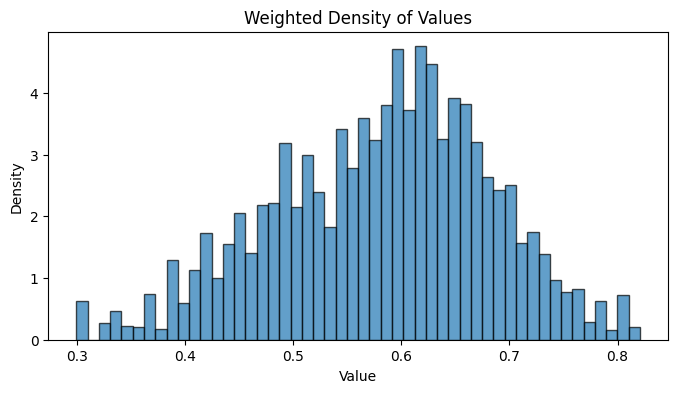

In [ ]:
value = Y[:,-1].cpu().numpy()
probability = sample_w[:,-1].cpu().numpy()
# calculate the distribution of the values under the probability distribution

# Plot the resulting density
import matplotlib.pyplot as plt

# Normalize the probability weights
probability = probability / probability.sum()

plt.figure(figsize=(8, 4))
plt.hist(value, bins=50, weights=probability, density=True, alpha=0.7, color='C0', edgecolor='k')
plt.xlabel("Value")
plt.ylabel("Density")
plt.title("Weighted Density of Values")
plt.show()
